## EE 782: Advanced Topics in Machine Learning
### **Assignment 2:** Metric Learning & Generative AI
> **NAME:** Munish Monga

> **ROLL NO:** 22M2153

> [Github Repo Link](https://github.com/munish30monga/Metric_Learning-Generative_AI)

### Table of Contents:
- [Introduction](#introduction)
- [Importing Libraries](#importing-libraries)
- [Hyperparameters](#hyperparameters)
- [References](#references)

### Introduction <a id="introduction"></a>
**PART A: Metric Learning using Siamese Network**
> We have to train a Siamese Network on Labeled Faces in the Wild (LFW) Dataset


**PART B: Generative AI using GANs**
> We have to train a generative model for generating face images, using a GAN.

### Importing Libraries <a id="importing-libraries"></a>

In [92]:
import pathlib as pl                                            # for path handling
import matplotlib.pyplot as plt                                 # for plotting
from PIL import Image                                           # for image handling
from sklearn.model_selection import train_test_split            # for splitting data
import random                                                   # for random number generation
import torch                                                    # for deep learning functionality
import numpy as np                                              # for numerical operations  
import matplotlib.pyplot as plt         

### Hyperparameters <a id="hyperparameters"></a>

In [77]:
batch_size = 128                                                    # batch size for training
random_seed = 42                                                    # for reproducibility
random.seed(random_seed)                                            # set random seed
device = 'cuda' if torch.cuda.is_available() else 'cpu'             # set device to cuda if available

## **PART A:** Metric Learning using Siamese Network <a id="part-a"></a>
### Downloading Dataset
> <font color="gray">Q1. Download labeled faces in the wild (LFW) dataset</font>

LFW Dataset was downloaded and extracted into the following path: `./dataset/lfw/`

### Exploring Dataset <a id="exploring-dataset"></a>

In [78]:
data_dir = pl.Path('./dataset/lfw/')     # Setting path to the data directory
persons_dirs = [d for d in data_dir.iterdir() if d.is_dir()] # List all subdirectories (each directory corresponds to a person)
all_persons_dict = {person_dir.name: len(list(person_dir.glob("*.jpg"))) for person_dir in persons_dirs} # Create a dictionary of all persons and the number of images they have
all_persons = list(all_persons_dict.keys())             # List of all persons

In [79]:
print(f"Total number of persons: {len(persons)}")  # Print the number of persons
for i, (person, num_images) in enumerate(all_persons_dict.items()):  # Loop through all persons dictionary
    if i >= 10:                     # Break the loop after printing 10 persons
        break
    print(f"{i+1}.{person}: {num_images}")  # Print the number of images for each person

Total number of persons: 5749
1.Demi_Moore: 4
2.Glen_Sather: 1
3.Carlos_De_Abreu: 1
4.Stacy_Dragila: 2
5.Donald_Keyser: 1
6.Megan_Mullally: 3
7.Roh_Moo-hyun: 32
8.Barbora_Strycova: 1
9.Peter_Camejo: 1
10.Bryan_Thomas: 1


> <font color="gray">Q2. Get the number of persons who have more than one image</font>

In [80]:
persons_with_mul_imgs_dict = {person: num_images for person, num_images in all_persons_dict.items() if num_images > 1}
print(f"Number of persons with more than one image: {len(persons_with_mul_imgs_dict)}")
for i, (person, num_images) in enumerate(persons_with_mul_imgs_dict.items()):
    if i >= 10:
        break
    print(f"{i+1}.{person}: {num_images}")

Number of persons with more than one image: 1680
1.Demi_Moore: 4
2.Stacy_Dragila: 2
3.Megan_Mullally: 3
4.Roh_Moo-hyun: 32
5.Erin_Runnion: 4
6.Diana_Taurasi: 2
7.Vaclav_Havel: 9
8.Tom_Watson: 3
9.John_Mayer: 3
10.Raghad_Saddam_Hussein: 2


In [65]:
def visualize(persons_dict):
    """
    Visualizes a grid of persons' images.
    """
    # Display in an 8x8 grid
    fig, axes = plt.subplots(8, 8, figsize=(15, 15))
    
    grid_position = 0  # Counter for the position in the 8x8 grid
    
    for person, count in persons_dict.items():
        if grid_position >= 64:  # Break after 64 cells
            break
        person_dir = data_dir / person
        images = list(person_dir.glob("*.jpg"))
        for img_path in images:
            if grid_position >= 64:  # Break after 64 cells
                break
            image = Image.open(img_path)
            image = image.resize((64, 64))
            row, col = divmod(grid_position, 8)
            axes[row, col].imshow(image)
            axes[row, col].axis('off')
            axes[row, col].set_title(f"{person}")
            grid_position += 1

    plt.tight_layout()
    plt.show()

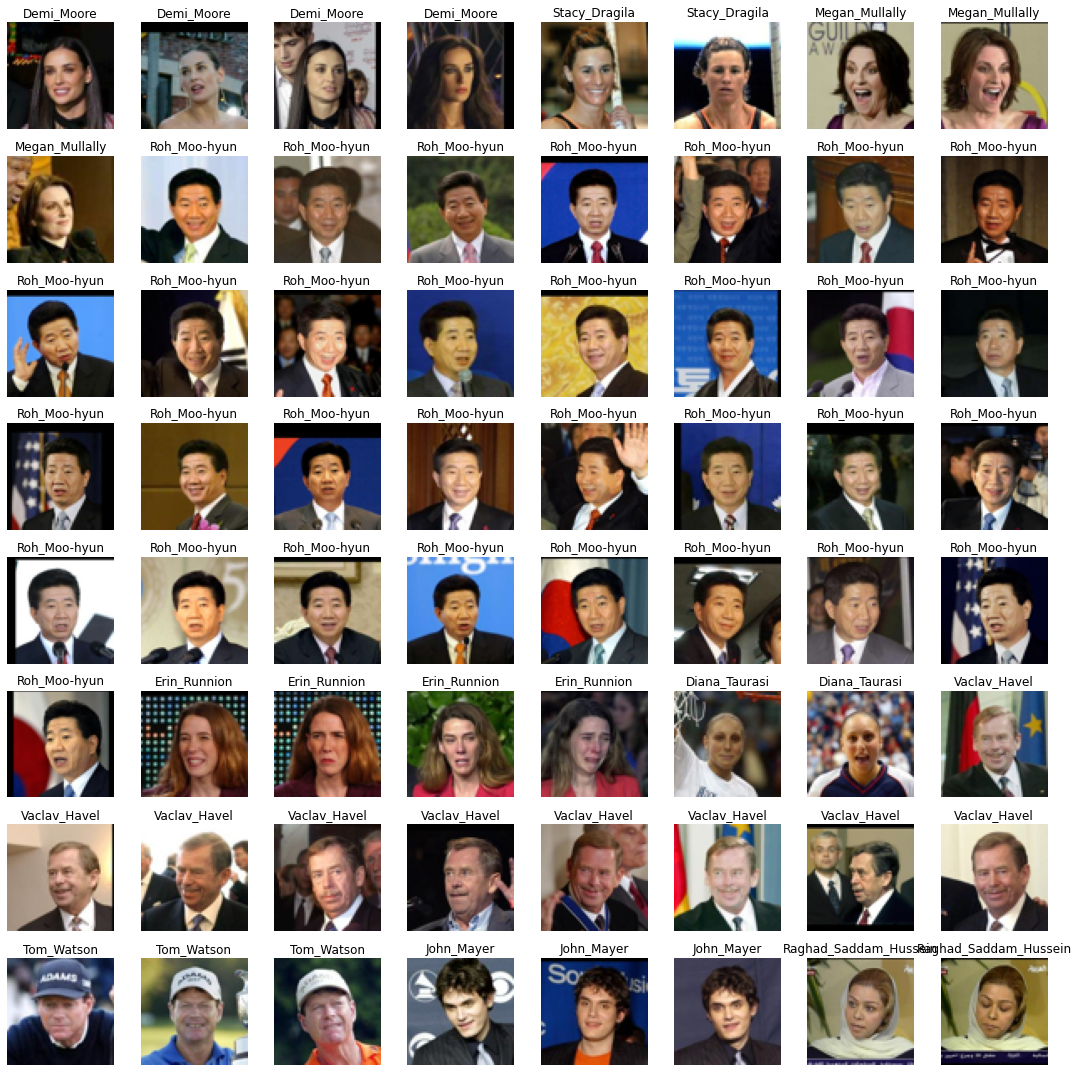

In [66]:
visualize(persons_with_mul_imgs_dict)

### Train-Test Split <a id="train-test-split"></a>
> <font color="gray">Q3. Split into training, validation, and testing by person (not by image)</font>

In [81]:
def split_data(persons_dict):
    """
    Split persons data for training a Siamese network.
    
    Args:
    - persons_dict (dict): Dictionary with person names as keys and the number of images as values.

    Returns:
    - train_persons_dict (dict): Dictionary for training set.
    - valid_persons_dict (dict): Dictionary for validation set.
    - test_persons_dict (dict): Dictionary for test set.
    """
    person_names = list(persons_dict.keys())
    
    # Split into 80% for training and 20% for validation + test
    train_persons, remaining_persons = train_test_split(person_names, test_size=0.2, random_state=42)
    
    # Split the remaining 20% equally into validation and test sets
    valid_persons, test_persons = train_test_split(remaining_persons, test_size=0.5, random_state=42)
    
    # Create dictionaries for each set
    train_persons_dict = {person: persons_dict[person] for person in train_persons}
    valid_persons_dict = {person: persons_dict[person] for person in valid_persons}
    test_persons_dict = {person: persons_dict[person] for person in test_persons}
    
    return train_persons_dict, valid_persons_dict, test_persons_dict

In [82]:
train_persons_dict, valid_persons_dict, test_persons_dict = split_data(persons_with_mul_imgs_dict)
print(f"Number of persons in Training Set: {len(train_persons_dict)}")
print(f"Number of persons in Validation Set {len(valid_persons_dict)}")
print(f"Number of persons in Test Set {len(test_persons_dict)}")

Number of persons in Training Set: 1344
Number of persons in Validation Set 168
Number of persons in Test Set 168


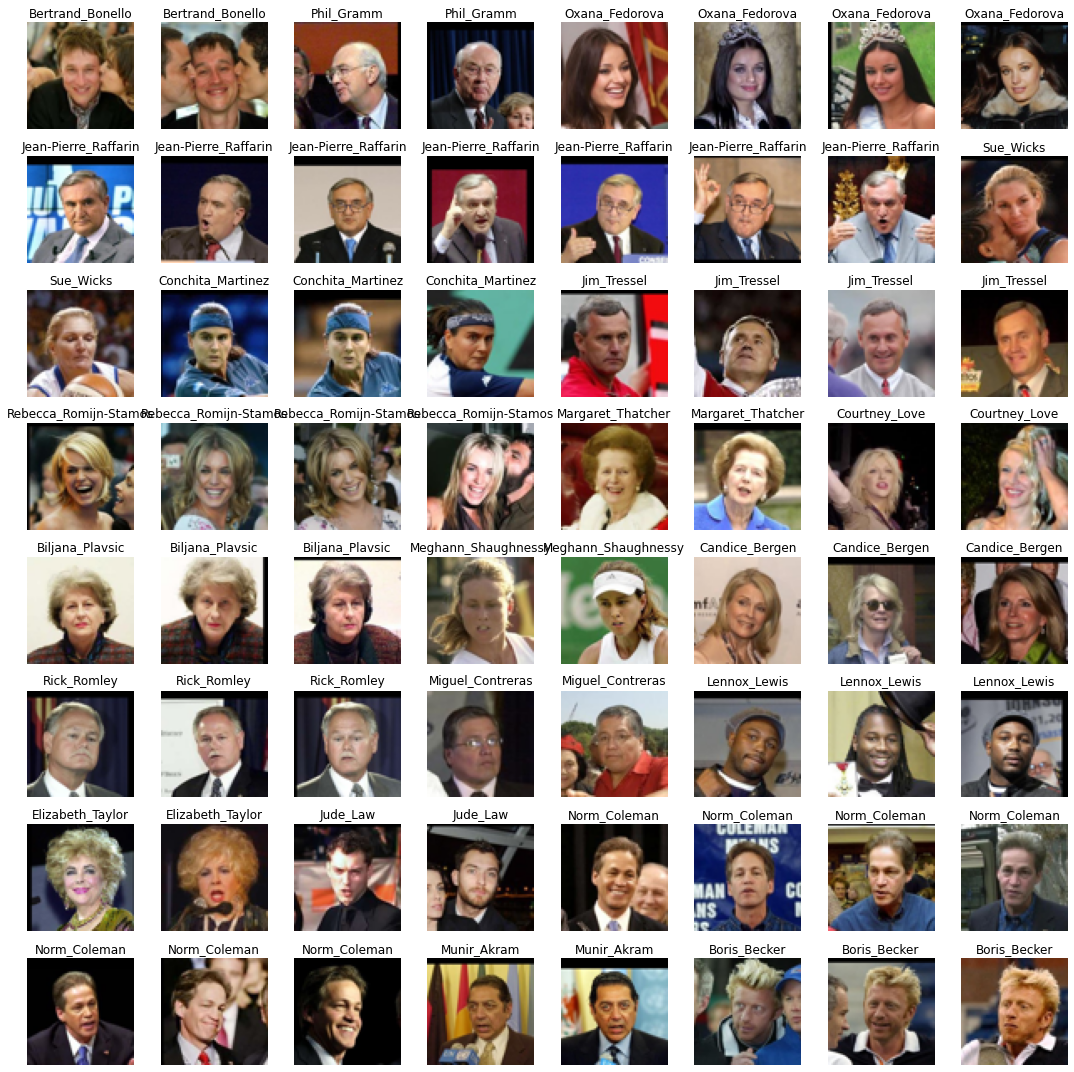

In [88]:
visualize(test_persons_dict)

In [109]:
def generate_pairs(persons_dict):
    X, Y = [], []

    person_names = list(persons_dict.keys())
    for idx, person in enumerate(person_names):
        person_dir = data_dir / person
        images = list(person_dir.glob("*.jpg"))

        # Generate positive pairs
        if len(images) >= 2:
            pair = random.sample(images, 2)
            X.append(pair)
            Y.append(1.0)  # Same person

        # Generate negative pairs
        other_person = random.choice(person_names[:idx] + person_names[idx+1:])
        other_person_dir = data_dir / other_person
        other_person_images = list(other_person_dir.glob("*.jpg"))

        if len(images) > 0 and len(other_person_images) > 0:
            img1 = random.choice(images)
            img2 = random.choice(other_person_images)
            X.append([img1, img2])
            Y.append(0.0)  # Different persons

    return X, Y

**Positive Pairs Generation**:
   - For each person in the list of `person_names`, the function identifies the directory specific to that person (`person_dir`).
   - It then retrieves all image paths for that person using the `glob` method.
   - If there are at least 2 images for that person (checked using `if len(images) >= 2:`), it randomly selects 2 distinct images from the available images of that person. This is achieved using `random.sample(images, 2)`.
   - This pair of images is appended to the `X` list.
   - Since this is a positive pair (both images are of the same person), a label of `1.0` is appended to the `y` list.

**Negative Pairs Generation**:
   - For each person in the list of `person_names`, the function selects another person (distinct from the current person) using the line: `other_person = random.choice(person_names[:idx] + person_names[idx+1:])`. This ensures that the `other_person` is not the current person.
   - It then identifies the directory specific to this `other_person` (`other_person_dir`) and retrieves all image paths for that other person.
   - A negative pair is created by randomly selecting one image from the current person and one image from the `other_person`.
   - This pair of images is appended to the `X` list.
   - Since this is a negative pair (the images are of two different persons), a label of `0.0` is appended to the `y` list.

For each person:
  - If they have at least two images, one positive pair is generated.
  - Regardless of the number of their images, one negative pair is generated (using one image of the current person and one image of a randomly selected different person). 


In [105]:
IMG_SHAPE = (1, 250, 250)

In [106]:
def dict_to_tensors(persons_dict):
    X, Y = generate_pairs(persons_dict)

    X_tensor = torch.empty((len(X), 2, *IMG_SHAPE)) # Shape: (num_pairs, 2, 1, 250, 250)
    for i, (img_path1, img_path2) in enumerate(X):
        image1 = Image.open(img_path1).convert("L")  # Convert to grayscale
        image2 = Image.open(img_path2).convert("L")  # Convert to grayscale

        X_tensor[i, 0] = torch.from_numpy(np.array(image1)).unsqueeze(0)  # Add channel dimension
        X_tensor[i, 1] = torch.from_numpy(np.array(image2)).unsqueeze(0)  # Add channel dimension

    y_tensor = torch.tensor(Y, dtype=torch.float32)

    return X_tensor, y_tensor

In [107]:
X_train, Y_train = dict_to_tensors(train_persons_dict, data_dir)
X_valid, Y_valid = dict_to_tensors(valid_persons_dict, data_dir)
X_test, Y_test = dict_to_tensors(test_persons_dict, data_dir)

In [108]:
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_valid shape: {X_valid.shape}, Y_valid shape: {Y_valid.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

X_train shape: torch.Size([2688, 2, 1, 250, 250]), Y_train shape: torch.Size([2688])
X_valid shape: torch.Size([336, 2, 1, 250, 250]), Y_valid shape: torch.Size([336])
X_test shape: torch.Size([336, 2, 1, 250, 250]), Y_test shape: torch.Size([336])


$\text{Shape of } X: (N, 2, C, H, W)$

$\text{Shape of } Y: (N,1)$

where:
- $N$: represents the Number of Image Pairs.
- $2$: represennts a pair (two images)
- $C$: represents the Number of channels in the image (1 as we keep it grayscale)
- $H$: represents the Height of the image
- $W$: represents the Width of the image

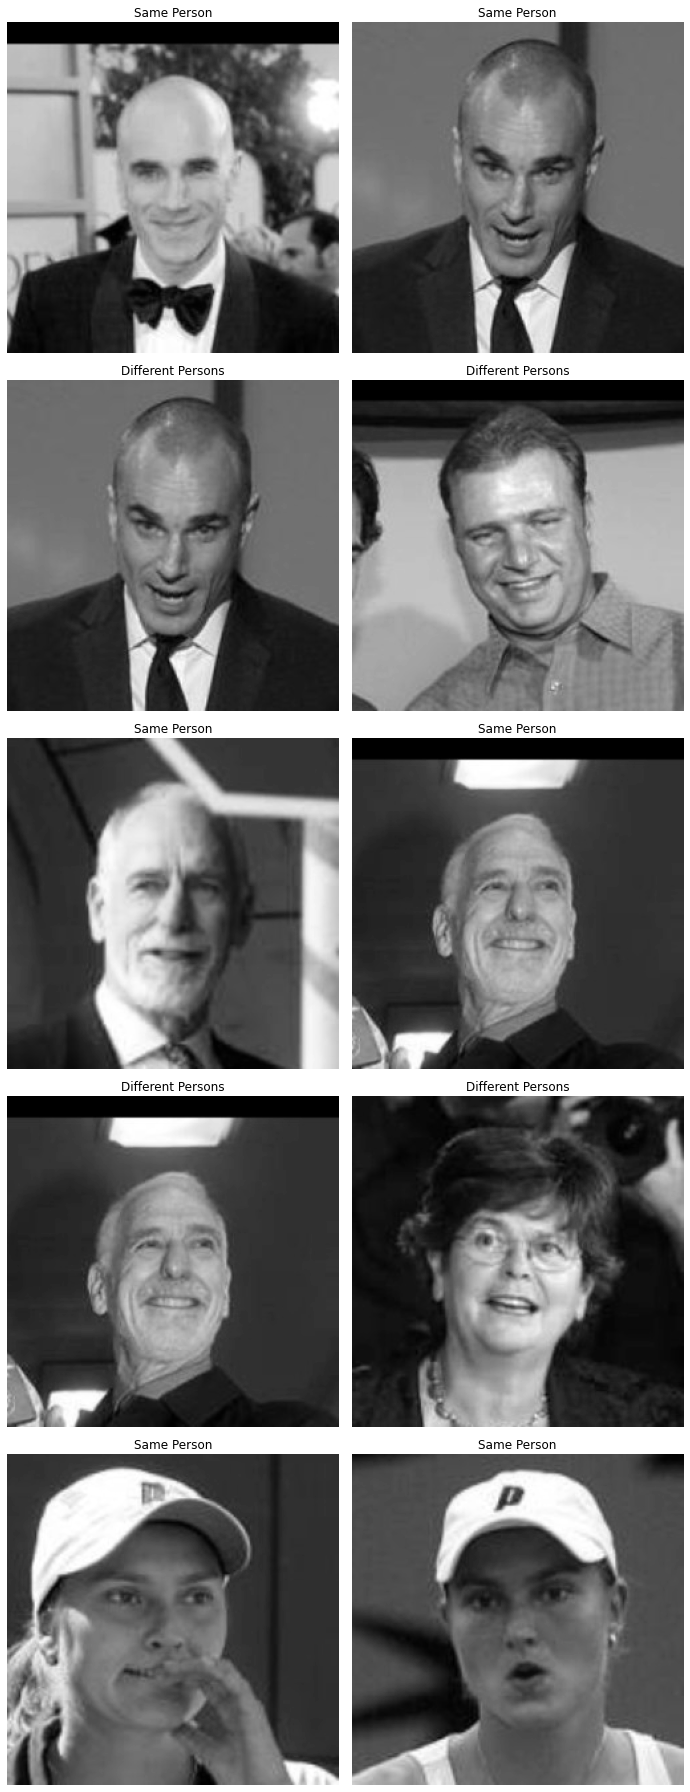

In [103]:
def visualize_pairs(X, y, num_pairs=5):
    """
    Visualizes pairs of images from X along with their label from Y.

    Args:
    - X (torch.Tensor): Tensor of image pairs.
    - y (torch.Tensor): Tensor of labels.
    - num_pairs (int): Number of pairs to visualize.
    """
    fig, axes = plt.subplots(num_pairs, 2, figsize=(10, 5*num_pairs))

    for idx in range(num_pairs):
        ax1, ax2 = axes[idx]

        # Get images
        img1 = X[idx, 0].squeeze().numpy()  # Remove channel dimension and convert to numpy
        img2 = X[idx, 1].squeeze().numpy()

        # Show images
        ax1.imshow(img1, cmap='gray')
        ax2.imshow(img2, cmap='gray')

        # Remove axes
        ax1.axis('off')
        ax2.axis('off')

        # Set title
        label = "Same Person" if y[idx] == 1 else "Different Persons"
        ax1.set_title(label)
        ax2.set_title(label)

    plt.tight_layout()
    plt.show()

# Usage:
visualize_pairs(X_train_tensor, y_train_tensor)


### References:   <a id="references"></a>
1.  https://github.com/Mitix-EPI/Face-Recognition-using-Siamese-Networks/tree/main
2.  https://chat.openai.com
3.  